In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import datetime
import io
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import sys
import os
# Obtener la ruta del directorio actual
os.chdir('/home/rgadea/experimentos_software_2024')
current_dir = os.getcwd()
print(current_dir)

# Construir la ruta relativa al directorio que quieres agregar
relative_dir = os.path.join(current_dir, 'mis_pkgs/')

# Agregar la ruta relativa al sys.path
sys.path.insert(0, relative_dir)

from MIOPATIA_db import DB_management as db 


2024-05-21 16:26:04.902333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 16:26:04.902389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 16:26:04.904776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 16:26:04.915914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/rgadea/experimentos_software_2024


Voy a quedarme con los 50 atunes P1 para obtener conjunto de training y validacion

In [2]:
!pwd


/home/rgadea/experimentos_software_2024


In [3]:
filename = "hdf_lomosP1P2_trainval_filtrado_def_good_ampliado_the_best7.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    # p_e =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_train=np.zeros((pre_p_e1.shape[0],220,8))
    y_train=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if estado == 0 or estado== 1:
            target = 1
        else:
            target = 0
        #target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_train[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_train[x]=target
        y_train_to_categorical = to_categorical(y_train)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_train_filtrado = X_train
#y_train_filtrado = y_train
y_train_filtrado = y_train_to_categorical

# print(X_train_filtrado.shape)
# print(y_train_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_2d = X_train_filtrado.reshape(-1, X_train_filtrado.shape[-1])
normalized_data_2d = scaler.fit_transform(data_2d)
X_train_Normalizado=normalized_data_2d.reshape(X_train_filtrado.shape)
y_train_Normalizado=y_train_filtrado # los valores ya estaban normalizados
print(y_train_Normalizado.shape)

(5907, 2)


In [4]:
filename = "hdf_lomosP1P2_test_filtrado_def_good.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    pre_p_e1 =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_test=np.zeros((pre_p_e1.shape[0],220,8))
    y_test=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if estado == 0 or estado== 1:
           target = 1
        else:
           target = 0
        #target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_test[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_test[x]=target
        y_test_to_categorical = to_categorical(y_test)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_test_filtrado = X_test
#y_train_filtrado = y_train
y_test_filtrado = y_test_to_categorical

print(X_test_filtrado.shape)
print(y_test_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
# concatenamos train y test
#X_total=np.concatenate((X_train_filtrado,X_test_filtrado),axis=0)
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_2d_test = X_total.reshape(-1, X_total.shape[-1])
data_2d_test = X_test_filtrado.reshape(-1, X_test_filtrado.shape[-1])
normalized_data_2d_test = scaler.transform(data_2d_test)


X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 
# la alternativa es normalizar con el total
# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 

y_test_def=y_test_filtrado # los valores ya estaban normalizados
print(X_test_def[0])

(176, 220, 8)
(176, 2)
[[3.73764140e-01 4.22950163e-01 2.73004947e-02 ... 5.77049837e-01
  3.73756468e-01 6.65796904e-01]
 [3.77897166e-01 4.15326043e-01 2.72960089e-02 ... 5.84673957e-01
  3.77887879e-01 6.53769355e-01]
 [3.71094548e-01 4.10647567e-01 2.73000169e-02 ... 5.89352433e-01
  3.71084466e-01 6.51193263e-01]
 ...
 [3.34509932e-04 3.16651268e-01 2.62077453e-02 ... 6.83348732e-01
  3.34478182e-04 8.46134111e-01]
 [3.20346260e-04 3.12631829e-01 2.62088742e-02 ... 6.87368171e-01
  3.20314636e-04 8.46141503e-01]
 [3.06488290e-04 3.10423025e-01 2.62093514e-02 ... 6.89576975e-01
  3.06457393e-04 8.46151049e-01]]


Vamos a hacer los conjuntos de entrenamiento validacion y test

In [5]:
# Divide el dataset en entrenamiento y temporal (test+validación)
# X_temp, X_test_def, y_temp, y_test_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.2, stratify=y_train_Normalizado, random_state=42)

# Divide el dataset temporal en validación y test
X_train_def, X_val_def, y_train_def, y_val_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.25, stratify=y_train_Normalizado, random_state=42)

# Ahora, X_train, X_val y X_test contienen los datos de entrada para los conjuntos de entrenamiento, validación y prueba, respectivamente.
# y_train, y_val y y_test contienen las clases correspondientes.

In [6]:
print(X_train_def.shape)
print(X_val_def.shape)
print(X_test_def.shape)
print(y_train_def.shape)
print(y_val_def.shape)
print(y_test_def.shape)

(4430, 220, 8)
(1477, 220, 8)
(176, 220, 8)
(4430, 2)
(1477, 2)
(176, 2)


In [7]:
%load_ext tensorboard

#%tensorboard --logdir logs
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [9]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    threshold = 0.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [10]:
factor_aprendizaje=0.001
dimension_LSTM=50
dimension_dense=50
algoritmo='RMSprop'
supermax=8*4
lossfunction='categorical_crossentropy'
def create_model():

    model = Sequential()
    model.add(GRU(dimension_LSTM, return_sequences=False,input_shape=(220, 8)))
    #model.add(Bidirectional(LSTM(50, return_sequences=True)))
    #model.add(Bidirectional(LSTM(50, return_sequences=True)))
    #model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dense(dimension_dense, activation='tanh'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=lossfunction, optimizer=algoritmo, metrics=['accuracy'])
    model.optimizer.lr=(factor_aprendizaje)
    return model

model=create_model()

2024-05-21 16:26:42.514485: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-21 16:26:42.514689: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: nodofpga-2024.novalocal
2024-05-21 16:26:42.514728: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: nodofpga-2024.novalocal
2024-05-21 16:26:42.514987: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-05-21 16:26:42.515215: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-05-21 16:26:42.515261: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.161.7


In [11]:

experimento="LOMOS_P2yP1_GRU2_2_clasesfiltrado_{}_dense_onehot_{}_loss_{}_lr_{}_algoritmo_{}".format(dimension_LSTM,dimension_dense,lossfunction,factor_aprendizaje,algoritmo)
logdir="./logs/defs/{}_{}".format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


In [12]:
class_names=["Buenos","Malos"]

In [13]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    y_pred = model.predict(X_test_def)
    #y_pred1=y_pred[:,-1]
    y_pred2=y_pred.argmax(axis=1)
    #y_pred2=np.where(y_pred>0,1,0)
    #y_pred2=y_pred2[:,-1]
    #classes = [0, 1, 2, 3, 4] 
    classes = [0, 1]
    y_test_def2=np.argmax(y_test_def,axis=1)  
    #y_test_def2=np.where(y_test_def>0,1,0)
    cm=confusion_matrix(y_test_def2, y_pred2,labels=classes)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    figura = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figura)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [14]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
print(y_train_Normalizado.shape)
print(y_val_def.shape)

(5907, 2)
(1477, 2)


In [15]:
# Crear un callback para guardar los mejores pesos
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [16]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
model.fit(X_train_Normalizado, y_train_Normalizado, epochs=400, batch_size=20, callbacks=[tensorboard_callback,cm_callback,checkpoint, early_stop], validation_data=(X_val_def, y_val_def))
# Final evaluation of the model 
scores = model.evaluate(X_test_def, y_test_def, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/400
6/6 [==============================] - 1s 28ms/step- loss: 0.6947 - accuracy: 

Epoch 1: val_loss improved from inf to 0.69067, saving model to best_weights.h5
296/296 [==============================] - 30s 94ms/step - loss: 0.6947 - accuracy: 0.5194 - val_loss: 0.6907 - val_accuracy: 0.5559
Epoch 2/400
  2/296 [..............................] - ETA: 22s - loss: 0.6982 - accuracy: 0.3750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 24ms/step- loss: 0.6914 - accuracy: 

Epoch 2: val_loss improved from 0.69067 to 0.68995, saving model to best_weights.h5
296/296 [==============================] - 24s 81ms/step - loss: 0.6914 - accuracy: 0.5221 - val_loss: 0.6899 - val_accuracy: 0.5220
Epoch 3/400
  2/296 [..............................] - ETA: 20s - loss: 0.6912 - accuracy: 0.4500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.6912 - accuracy: 0.

Epoch 3: val_loss did not improve from 0.68995
296/296 [==============================] - 24s 82ms/step - loss: 0.6912 - accuracy: 0.5255 - val_loss: 0.6957 - val_accuracy: 0.5003
Epoch 4/400
6/6 [==============================] - 0s 23ms/step- loss: 0.6904 - accuracy: 0.

Epoch 4: val_loss improved from 0.68995 to 0.68979, saving model to best_weights.h5
296/296 [==============================] - 24s 80ms/step - loss: 0.6904 - accuracy: 0.5289 - val_loss: 0.6898 - val_accuracy: 0.5403
Epoch 5/400
  2/296 [..............................] - ETA: 23s - loss: 0.6834 - accuracy: 0.6000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.6903 - accuracy: 0.

Epoch 5: val_loss did not improve from 0.68979
296/296 [==============================] - 24s 81ms/step - loss: 0.6903 - accuracy: 0.5350 - val_loss: 0.6904 - val_accuracy: 0.5173
Epoch 6/400
6/6 [==============================] - 0s 22ms/step- loss: 0.6898 - accuracy: 0.

Epoch 6: val_loss did not improve from 0.68979
296/296 [==============================] - 25s 84ms/step - loss: 0.6898 - accuracy: 0.5339 - val_loss: 0.6940 - val_accuracy: 0.5179
Epoch 7/400
6/6 [==============================] - 0s 21ms/step- loss: 0.6898 - accuracy: 0.

Epoch 7: val_loss improved from 0.68979 to 0.68974, saving model to best_weights.h5
296/296 [==============================] - 24s 81ms/step - loss: 0.6898 - accuracy: 0.5326 - val_loss: 0.6897 - val_accuracy: 0.5322
Epoch 8/400
  2/296 [..............................] - ETA: 23s - loss: 0.6418 - accuracy: 0.7000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 23ms/step- loss: 0.6888 - accuracy: 0.

Epoch 8: val_loss did not improve from 0.68974
296/296 [==============================] - 24s 82ms/step - loss: 0.6888 - accuracy: 0.5322 - val_loss: 0.6910 - val_accuracy: 0.5274
Epoch 9/400
6/6 [==============================] - 0s 23ms/step- loss: 0.6890 - accuracy: 0.

Epoch 9: val_loss improved from 0.68974 to 0.68821, saving model to best_weights.h5
296/296 [==============================] - 25s 84ms/step - loss: 0.6890 - accuracy: 0.5361 - val_loss: 0.6882 - val_accuracy: 0.5450
Epoch 10/400
  2/296 [..............................] - ETA: 21s - loss: 0.7009 - accuracy: 0.5250

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.6878 - accuracy: 0.

Epoch 10: val_loss improved from 0.68821 to 0.68506, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.6878 - accuracy: 0.5267 - val_loss: 0.6851 - val_accuracy: 0.5328
Epoch 11/400
  2/296 [..............................] - ETA: 25s - loss: 0.6401 - accuracy: 0.5750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.6869 - accuracy: 0.

Epoch 11: val_loss improved from 0.68506 to 0.68362, saving model to best_weights.h5
296/296 [==============================] - 24s 83ms/step - loss: 0.6869 - accuracy: 0.5292 - val_loss: 0.6836 - val_accuracy: 0.5538
Epoch 12/400
  2/296 [..............................] - ETA: 19s - loss: 0.6959 - accuracy: 0.5500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.6850 - accuracy: 0.

Epoch 12: val_loss did not improve from 0.68362
296/296 [==============================] - 24s 81ms/step - loss: 0.6850 - accuracy: 0.5443 - val_loss: 0.6863 - val_accuracy: 0.5355
Epoch 13/400
6/6 [==============================] - 0s 24ms/step- loss: 0.6847 - accuracy: 0.

Epoch 13: val_loss improved from 0.68362 to 0.68140, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.6847 - accuracy: 0.5470 - val_loss: 0.6814 - val_accuracy: 0.5613
Epoch 14/400
  2/296 [..............................] - ETA: 22s - loss: 0.6975 - accuracy: 0.4250

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.6828 - accuracy: 0.

Epoch 14: val_loss did not improve from 0.68140
296/296 [==============================] - 25s 83ms/step - loss: 0.6828 - accuracy: 0.5620 - val_loss: 0.7008 - val_accuracy: 0.5687
Epoch 15/400
6/6 [==============================] - 0s 20ms/step- loss: 0.6774 - accuracy: 0.

Epoch 15: val_loss improved from 0.68140 to 0.66919, saving model to best_weights.h5
296/296 [==============================] - 25s 83ms/step - loss: 0.6774 - accuracy: 0.5612 - val_loss: 0.6692 - val_accuracy: 0.5958
Epoch 16/400
  2/296 [..............................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 18ms/step- loss: 0.6785 - accuracy: 0.

Epoch 16: val_loss did not improve from 0.66919
296/296 [==============================] - 22s 75ms/step - loss: 0.6785 - accuracy: 0.5575 - val_loss: 0.6783 - val_accuracy: 0.5308
Epoch 17/400
6/6 [==============================] - 0s 23ms/step- loss: 0.6760 - accuracy: 0.

Epoch 17: val_loss did not improve from 0.66919
296/296 [==============================] - 22s 75ms/step - loss: 0.6760 - accuracy: 0.5683 - val_loss: 0.6720 - val_accuracy: 0.5850
Epoch 18/400
6/6 [==============================] - 0s 20ms/step- loss: 0.6716 - accuracy: 0.

Epoch 18: val_loss did not improve from 0.66919
296/296 [==============================] - 24s 82ms/step - loss: 0.6716 - accuracy: 0.5791 - val_loss: 0.6873 - val_accuracy: 0.5525
Epoch 19/400
6/6 [==============================] - 0s 25ms/step- loss: 0.6706 - accuracy: 

Epoch 19: val_loss did not improve from 0.66919
296/296 [==============================] - 2

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.6784 - accuracy: 0.

Epoch 21: val_loss did not improve from 0.65960
296/296 [==============================] - 24s 83ms/step - loss: 0.6784 - accuracy: 0.5646 - val_loss: 0.6636 - val_accuracy: 0.6080
Epoch 22/400
6/6 [==============================] - 0s 19ms/step- loss: 0.6695 - accuracy: 0.

Epoch 22: val_loss did not improve from 0.65960
296/296 [==============================] - 25s 83ms/step - loss: 0.6695 - accuracy: 0.5939 - val_loss: 0.7005 - val_accuracy: 0.5809
Epoch 23/400
6/6 [==============================] - 0s 23ms/step- loss: 0.6682 - accuracy: 0.

Epoch 23: val_loss did not improve from 0.65960
296/296 [==============================] - 25s 83ms/step - loss: 0.6682 - accuracy: 0.5891 - val_loss: 0.6781 - val_accuracy: 0.5511
Epoch 24/400
6/6 [==============================] - 0s 19ms/step- loss: 0.6671 - accuracy: 0.

Epoch 24: val_loss did not improve from 0.65960
296/296 [==============================] -

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.6647 - accuracy: 0.

Epoch 26: val_loss did not improve from 0.64483
296/296 [==============================] - 25s 84ms/step - loss: 0.6647 - accuracy: 0.5954 - val_loss: 0.6567 - val_accuracy: 0.6046
Epoch 27/400
6/6 [==============================] - 0s 24ms/step- loss: 0.6681 - accuracy: 0.

Epoch 27: val_loss did not improve from 0.64483
296/296 [==============================] - 24s 83ms/step - loss: 0.6681 - accuracy: 0.5983 - val_loss: 0.6639 - val_accuracy: 0.5518
Epoch 28/400
6/6 [==============================] - 0s 20ms/step- loss: 0.6662 - accuracy: 0.

Epoch 28: val_loss did not improve from 0.64483
296/296 [==============================] - 25s 86ms/step - loss: 0.6662 - accuracy: 0.5964 - val_loss: 0.6618 - val_accuracy: 0.5843
Epoch 29/400
6/6 [==============================] - 0s 19ms/step- loss: 0.6667 - accuracy: 0.

Epoch 29: val_loss did not improve from 0.64483
296/296 [==============================] -

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.6468 - accuracy: 0.

Epoch 38: val_loss improved from 0.63449 to 0.62372, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.6468 - accuracy: 0.6247 - val_loss: 0.6237 - val_accuracy: 0.6114
Epoch 39/400
  2/296 [..............................] - ETA: 24s - loss: 0.6196 - accuracy: 0.5500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.6351 - accuracy: 0.

Epoch 39: val_loss did not improve from 0.62372
296/296 [==============================] - 24s 81ms/step - loss: 0.6351 - accuracy: 0.6330 - val_loss: 0.6629 - val_accuracy: 0.5965
Epoch 40/400
6/6 [==============================] - 0s 21ms/step- loss: 0.6263 - accuracy: 0.

Epoch 40: val_loss did not improve from 0.62372
296/296 [==============================] - 25s 83ms/step - loss: 0.6263 - accuracy: 0.6301 - val_loss: 0.6685 - val_accuracy: 0.6093
Epoch 41/400
6/6 [==============================] - 0s 21ms/step- loss: 0.6203 - accuracy: 0.

Epoch 41: val_loss improved from 0.62372 to 0.62071, saving model to best_weights.h5
296/296 [==============================] - 25s 85ms/step - loss: 0.6203 - accuracy: 0.6397 - val_loss: 0.6207 - val_accuracy: 0.6263
Epoch 42/400
  2/296 [..............................] - ETA: 24s - loss: 0.5833 - accuracy: 0.6750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.6080 - accuracy: 0.

Epoch 42: val_loss improved from 0.62071 to 0.59830, saving model to best_weights.h5
296/296 [==============================] - 25s 83ms/step - loss: 0.6080 - accuracy: 0.6430 - val_loss: 0.5983 - val_accuracy: 0.6439
Epoch 43/400
  2/296 [..............................] - ETA: 19s - loss: 0.5389 - accuracy: 0.7000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.6011 - accuracy: 0.

Epoch 43: val_loss did not improve from 0.59830
296/296 [==============================] - 24s 81ms/step - loss: 0.6011 - accuracy: 0.6604 - val_loss: 0.9309 - val_accuracy: 0.5863
Epoch 44/400
6/6 [==============================] - 0s 21ms/step- loss: 0.5931 - accuracy: 0.

Epoch 44: val_loss did not improve from 0.59830
296/296 [==============================] - 25s 83ms/step - loss: 0.5931 - accuracy: 0.6626 - val_loss: 0.6502 - val_accuracy: 0.5775
Epoch 45/400
6/6 [==============================] - 0s 23ms/step- loss: 0.5843 - accuracy: 

Epoch 45: val_loss improved from 0.59830 to 0.58699, saving model to best_weights.h5
296/296 [==============================] - 25s 84ms/step - loss: 0.5843 - accuracy: 0.6704 - val_loss: 0.5870 - val_accuracy: 0.6757
Epoch 46/400
  2/296 [..............................] - ETA: 21s - loss: 0.6062 - accuracy: 0.5000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 19ms/step- loss: 0.5770 - accuracy: 0.

Epoch 46: val_loss did not improve from 0.58699
296/296 [==============================] - 25s 84ms/step - loss: 0.5770 - accuracy: 0.6697 - val_loss: 0.6249 - val_accuracy: 0.5965
Epoch 47/400
6/6 [==============================] - 0s 20ms/step- loss: 0.5639 - accuracy: 0.

Epoch 47: val_loss improved from 0.58699 to 0.58253, saving model to best_weights.h5
296/296 [==============================] - 25s 84ms/step - loss: 0.5639 - accuracy: 0.6865 - val_loss: 0.5825 - val_accuracy: 0.6798
Epoch 48/400
  2/296 [..............................] - ETA: 28s - loss: 0.6253 - accuracy: 0.6250

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.5602 - accuracy: 0.

Epoch 48: val_loss improved from 0.58253 to 0.55232, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.5602 - accuracy: 0.6905 - val_loss: 0.5523 - val_accuracy: 0.7123
Epoch 49/400
  2/296 [..............................] - ETA: 22s - loss: 0.6215 - accuracy: 0.6500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.5515 - accuracy: 0.

Epoch 49: val_loss improved from 0.55232 to 0.54242, saving model to best_weights.h5
296/296 [==============================] - 24s 81ms/step - loss: 0.5515 - accuracy: 0.6995 - val_loss: 0.5424 - val_accuracy: 0.6919
Epoch 50/400
  2/296 [..............................] - ETA: 21s - loss: 0.4289 - accuracy: 0.7750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.5344 - accuracy: 0.

Epoch 50: val_loss improved from 0.54242 to 0.52650, saving model to best_weights.h5
296/296 [==============================] - 24s 81ms/step - loss: 0.5344 - accuracy: 0.7154 - val_loss: 0.5265 - val_accuracy: 0.7332
Epoch 51/400
  2/296 [..............................] - ETA: 23s - loss: 0.4457 - accuracy: 0.7250

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 19ms/step- loss: 0.5328 - accuracy: 0.

Epoch 51: val_loss did not improve from 0.52650
296/296 [==============================] - 24s 82ms/step - loss: 0.5328 - accuracy: 0.7134 - val_loss: 0.7371 - val_accuracy: 0.6703
Epoch 52/400
6/6 [==============================] - 0s 21ms/step- loss: 0.5679 - accuracy: 0.

Epoch 52: val_loss improved from 0.52650 to 0.50942, saving model to best_weights.h5
296/296 [==============================] - 25s 83ms/step - loss: 0.5679 - accuracy: 0.7124 - val_loss: 0.5094 - val_accuracy: 0.7217
Epoch 53/400
  2/296 [..............................] - ETA: 24s - loss: 0.5102 - accuracy: 0.7750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.5309 - accuracy: 0.

Epoch 53: val_loss did not improve from 0.50942
296/296 [==============================] - 24s 81ms/step - loss: 0.5309 - accuracy: 0.7142 - val_loss: 0.5920 - val_accuracy: 0.6310
Epoch 54/400
6/6 [==============================] - 0s 22ms/step- loss: 0.5322 - accuracy: 0.

Epoch 54: val_loss did not improve from 0.50942
296/296 [==============================] - 24s 81ms/step - loss: 0.5322 - accuracy: 0.7298 - val_loss: 0.5465 - val_accuracy: 0.6791
Epoch 55/400
6/6 [==============================] - 0s 20ms/step- loss: 0.5001 - accuracy: 0.

Epoch 55: val_loss did not improve from 0.50942
296/296 [==============================] - 24s 82ms/step - loss: 0.5001 - accuracy: 0.7390 - val_loss: 0.5380 - val_accuracy: 0.7590
Epoch 56/400
6/6 [==============================] - 0s 21ms/step- loss: 0.4810 - accuracy: 0.

Epoch 56: val_loss did not improve from 0.50942
296/296 [==============================] -

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 25ms/step- loss: 0.4553 - accuracy: 0.

Epoch 59: val_loss improved from 0.49642 to 0.48766, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.4553 - accuracy: 0.7811 - val_loss: 0.4877 - val_accuracy: 0.7387
Epoch 60/400
  2/296 [..............................] - ETA: 21s - loss: 0.4146 - accuracy: 0.8750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 23ms/step- loss: 0.4453 - accuracy: 

Epoch 60: val_loss improved from 0.48766 to 0.45438, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.4453 - accuracy: 0.7892 - val_loss: 0.4544 - val_accuracy: 0.7712
Epoch 61/400
  2/296 [..............................] - ETA: 22s - loss: 0.3413 - accuracy: 0.8500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.4458 - accuracy: 0.

Epoch 61: val_loss improved from 0.45438 to 0.44326, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.4458 - accuracy: 0.7930 - val_loss: 0.4433 - val_accuracy: 0.7820
Epoch 62/400
  2/296 [..............................] - ETA: 21s - loss: 0.6215 - accuracy: 0.7500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 24ms/step- loss: 0.4274 - accuracy: 

Epoch 62: val_loss improved from 0.44326 to 0.41340, saving model to best_weights.h5
296/296 [==============================] - 25s 85ms/step - loss: 0.4274 - accuracy: 0.7970 - val_loss: 0.4134 - val_accuracy: 0.8016
Epoch 63/400
  2/296 [..............................] - ETA: 22s - loss: 0.4339 - accuracy: 0.8250

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 19ms/step- loss: 0.4299 - accuracy: 0.

Epoch 63: val_loss improved from 0.41340 to 0.41238, saving model to best_weights.h5
296/296 [==============================] - 24s 83ms/step - loss: 0.4299 - accuracy: 0.7982 - val_loss: 0.4124 - val_accuracy: 0.7989
Epoch 64/400
  2/296 [..............................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.4250 - accuracy: 0.

Epoch 64: val_loss did not improve from 0.41238
296/296 [==============================] - 24s 82ms/step - loss: 0.4250 - accuracy: 0.8033 - val_loss: 0.4252 - val_accuracy: 0.7894
Epoch 65/400
6/6 [==============================] - 0s 22ms/step- loss: 0.4339 - accuracy: 0.

Epoch 65: val_loss improved from 0.41238 to 0.40677, saving model to best_weights.h5
296/296 [==============================] - 25s 84ms/step - loss: 0.4339 - accuracy: 0.7931 - val_loss: 0.4068 - val_accuracy: 0.8186
Epoch 66/400
  2/296 [..............................] - ETA: 20s - loss: 0.4749 - accuracy: 0.7500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.5209 - accuracy: 0.

Epoch 66: val_loss did not improve from 0.40677
296/296 [==============================] - 25s 83ms/step - loss: 0.5209 - accuracy: 0.7530 - val_loss: 0.4798 - val_accuracy: 0.7603
Epoch 67/400
6/6 [==============================] - 0s 28ms/step- loss: 0.4152 - accuracy: 

Epoch 67: val_loss did not improve from 0.40677
296/296 [==============================] - 24s 80ms/step - loss: 0.4152 - accuracy: 0.8011 - val_loss: 0.4540 - val_accuracy: 0.7833
Epoch 68/400
6/6 [==============================] - 0s 21ms/step- loss: 0.3970 - accuracy: 0.

Epoch 68: val_loss did not improve from 0.40677
296/296 [==============================] - 25s 83ms/step - loss: 0.3970 - accuracy: 0.8214 - val_loss: 0.4230 - val_accuracy: 0.7962
Epoch 69/400
6/6 [==============================] - 0s 22ms/step- loss: 0.3962 - accuracy: 0.

Epoch 69: val_loss did not improve from 0.40677
296/296 [==============================] - 2

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 27ms/step- loss: 0.3886 - accuracy: 

Epoch 73: val_loss did not improve from 0.37316
296/296 [==============================] - 24s 81ms/step - loss: 0.3886 - accuracy: 0.8319 - val_loss: 0.4064 - val_accuracy: 0.8077
Epoch 74/400
6/6 [==============================] - 0s 21ms/step- loss: 0.3887 - accuracy: 0.

Epoch 74: val_loss improved from 0.37316 to 0.36968, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.3887 - accuracy: 0.8270 - val_loss: 0.3697 - val_accuracy: 0.8517
Epoch 75/400
  1/296 [..............................] - ETA: 28s - loss: 0.5292 - accuracy: 0.7500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.3846 - accuracy: 0.

Epoch 75: val_loss improved from 0.36968 to 0.36377, saving model to best_weights.h5
296/296 [==============================] - 24s 81ms/step - loss: 0.3846 - accuracy: 0.8290 - val_loss: 0.3638 - val_accuracy: 0.8037
Epoch 76/400
  2/296 [..............................] - ETA: 20s - loss: 0.2950 - accuracy: 0.8500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 23ms/step- loss: 0.3656 - accuracy: 0.

Epoch 76: val_loss did not improve from 0.36377
296/296 [==============================] - 24s 81ms/step - loss: 0.3656 - accuracy: 0.8349 - val_loss: 0.3748 - val_accuracy: 0.8219
Epoch 77/400
6/6 [==============================] - 0s 19ms/step- loss: 0.4626 - accuracy: 0.

Epoch 77: val_loss did not improve from 0.36377
296/296 [==============================] - 25s 86ms/step - loss: 0.4626 - accuracy: 0.8009 - val_loss: 0.4300 - val_accuracy: 0.7915
Epoch 78/400
6/6 [==============================] - 0s 20ms/step- loss: 0.3574 - accuracy: 0.

Epoch 78: val_loss did not improve from 0.36377
296/296 [==============================] - 25s 86ms/step - loss: 0.3574 - accuracy: 0.8463 - val_loss: 0.4181 - val_accuracy: 0.8003
Epoch 79/400
6/6 [==============================] - 0s 21ms/step- loss: 0.3754 - accuracy: 0.

Epoch 79: val_loss did not improve from 0.36377
296/296 [==============================] -

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.3793 - accuracy: 0.

Epoch 81: val_loss did not improve from 0.28935
296/296 [==============================] - 24s 82ms/step - loss: 0.3793 - accuracy: 0.8373 - val_loss: 0.4420 - val_accuracy: 0.7888
Epoch 82/400
6/6 [==============================] - 0s 22ms/step- loss: 0.3481 - accuracy: 0.

Epoch 82: val_loss did not improve from 0.28935
296/296 [==============================] - 24s 82ms/step - loss: 0.3481 - accuracy: 0.8468 - val_loss: 0.3124 - val_accuracy: 0.8673
Epoch 83/400
6/6 [==============================] - 0s 21ms/step- loss: 0.3359 - accuracy: 0.

Epoch 83: val_loss did not improve from 0.28935
296/296 [==============================] - 25s 84ms/step - loss: 0.3359 - accuracy: 0.8541 - val_loss: 0.3424 - val_accuracy: 0.8422
Epoch 84/400
6/6 [==============================] - 0s 23ms/step- loss: 0.3395 - accuracy: 0.

Epoch 84: val_loss did not improve from 0.28935
296/296 [==============================] -

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 19ms/step- loss: 0.2638 - accuracy: 0.

Epoch 97: val_loss improved from 0.27770 to 0.26719, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.2638 - accuracy: 0.8903 - val_loss: 0.2672 - val_accuracy: 0.8863
Epoch 98/400
  2/296 [..............................] - ETA: 21s - loss: 0.2477 - accuracy: 0.9000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.2550 - accuracy: 0.

Epoch 98: val_loss did not improve from 0.26719
296/296 [==============================] - 24s 82ms/step - loss: 0.2550 - accuracy: 0.8940 - val_loss: 0.2824 - val_accuracy: 0.8896
Epoch 99/400
6/6 [==============================] - 0s 20ms/step- loss: 0.2608 - accuracy: 0.

Epoch 99: val_loss did not improve from 0.26719
296/296 [==============================] - 24s 83ms/step - loss: 0.2608 - accuracy: 0.8911 - val_loss: 0.3987 - val_accuracy: 0.8158
Epoch 100/400
6/6 [==============================] - 0s 21ms/step- loss: 0.2541 - accuracy: 0.

Epoch 100: val_loss improved from 0.26719 to 0.20834, saving model to best_weights.h5
296/296 [==============================] - 25s 83ms/step - loss: 0.2541 - accuracy: 0.8932 - val_loss: 0.2083 - val_accuracy: 0.9174
Epoch 101/400
  2/296 [..............................] - ETA: 21s - loss: 0.1801 - accuracy: 0.9500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.2865 - accuracy: 0.

Epoch 101: val_loss did not improve from 0.20834
296/296 [==============================] - 24s 82ms/step - loss: 0.2865 - accuracy: 0.8901 - val_loss: 0.4110 - val_accuracy: 0.7888
Epoch 102/400
6/6 [==============================] - 0s 20ms/step- loss: 0.2540 - accuracy: 0.

Epoch 102: val_loss improved from 0.20834 to 0.20272, saving model to best_weights.h5
296/296 [==============================] - 24s 81ms/step - loss: 0.2540 - accuracy: 0.8944 - val_loss: 0.2027 - val_accuracy: 0.9174
Epoch 103/400
  2/296 [..............................] - ETA: 22s - loss: 0.1754 - accuracy: 0.9500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 27ms/step- loss: 0.2327 - accuracy: 

Epoch 103: val_loss did not improve from 0.20272
296/296 [==============================] - 24s 81ms/step - loss: 0.2327 - accuracy: 0.9098 - val_loss: 0.3449 - val_accuracy: 0.8531
Epoch 104/400
6/6 [==============================] - 0s 21ms/step- loss: 0.2493 - accuracy: 0.

Epoch 104: val_loss did not improve from 0.20272
296/296 [==============================] - 25s 85ms/step - loss: 0.2493 - accuracy: 0.9016 - val_loss: 0.2468 - val_accuracy: 0.8842
Epoch 105/400
6/6 [==============================] - 0s 21ms/step- loss: 0.2396 - accuracy: 0.

Epoch 105: val_loss did not improve from 0.20272
296/296 [==============================] - 24s 82ms/step - loss: 0.2396 - accuracy: 0.9037 - val_loss: 0.2726 - val_accuracy: 0.8714
Epoch 106/400
6/6 [==============================] - 0s 23ms/step- loss: 0.2347 - accuracy: 

Epoch 106: val_loss did not improve from 0.20272
296/296 [==============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 17ms/step- loss: 0.1978 - accuracy: 0.

Epoch 115: val_loss did not improve from 0.17366
296/296 [==============================] - 24s 83ms/step - loss: 0.1978 - accuracy: 0.9253 - val_loss: 0.1762 - val_accuracy: 0.9282
Epoch 116/400
6/6 [==============================] - 0s 19ms/step- loss: 0.2153 - accuracy: 0.

Epoch 116: val_loss did not improve from 0.17366
296/296 [==============================] - 24s 81ms/step - loss: 0.2153 - accuracy: 0.9179 - val_loss: 0.2131 - val_accuracy: 0.9079
Epoch 117/400
6/6 [==============================] - 0s 22ms/step- loss: 0.1933 - accuracy: 0.

Epoch 117: val_loss improved from 0.17366 to 0.16870, saving model to best_weights.h5
296/296 [==============================] - 25s 83ms/step - loss: 0.1933 - accuracy: 0.9296 - val_loss: 0.1687 - val_accuracy: 0.9404
Epoch 118/400
  2/296 [..............................] - ETA: 24s - loss: 0.3139 - accuracy: 0.8750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 28ms/step- loss: 0.2310 - accuracy: 

Epoch 118: val_loss did not improve from 0.16870
296/296 [==============================] - 25s 83ms/step - loss: 0.2310 - accuracy: 0.9182 - val_loss: 0.3044 - val_accuracy: 0.8646
Epoch 119/400
6/6 [==============================] - 0s 20ms/step- loss: 0.2145 - accuracy: 0.

Epoch 119: val_loss did not improve from 0.16870
296/296 [==============================] - 24s 81ms/step - loss: 0.2145 - accuracy: 0.9199 - val_loss: 0.2947 - val_accuracy: 0.8720
Epoch 120/400
6/6 [==============================] - 0s 22ms/step- loss: 0.1889 - accuracy: 0.

Epoch 120: val_loss did not improve from 0.16870
296/296 [==============================] - 24s 81ms/step - loss: 0.1889 - accuracy: 0.9294 - val_loss: 0.2481 - val_accuracy: 0.8896
Epoch 121/400
6/6 [==============================] - 0s 21ms/step- loss: 0.1866 - accuracy: 0.

Epoch 121: val_loss did not improve from 0.16870
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 29ms/step- loss: 0.1588 - accuracy: 

Epoch 130: val_loss improved from 0.16834 to 0.10867, saving model to best_weights.h5
296/296 [==============================] - 24s 81ms/step - loss: 0.1588 - accuracy: 0.9453 - val_loss: 0.1087 - val_accuracy: 0.9682
Epoch 131/400
  1/296 [..............................] - ETA: 30s - loss: 0.0738 - accuracy: 1.0000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 25ms/step- loss: 0.1605 - accuracy: 

Epoch 131: val_loss did not improve from 0.10867
296/296 [==============================] - 25s 85ms/step - loss: 0.1605 - accuracy: 0.9401 - val_loss: 0.3981 - val_accuracy: 0.8152
Epoch 132/400
6/6 [==============================] - 0s 22ms/step- loss: 0.1631 - accuracy: 0.

Epoch 132: val_loss did not improve from 0.10867
296/296 [==============================] - 24s 83ms/step - loss: 0.1631 - accuracy: 0.9372 - val_loss: 0.1402 - val_accuracy: 0.9397
Epoch 133/400
6/6 [==============================] - 0s 20ms/step- loss: 0.1649 - accuracy: 0.

Epoch 133: val_loss did not improve from 0.10867
296/296 [==============================] - 24s 80ms/step - loss: 0.1649 - accuracy: 0.9399 - val_loss: 0.1735 - val_accuracy: 0.9296
Epoch 134/400
6/6 [==============================] - 0s 22ms/step- loss: 0.1701 - accuracy: 0.

Epoch 134: val_loss did not improve from 0.10867
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.1491 - accuracy: 0.

Epoch 137: val_loss improved from 0.08803 to 0.08747, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.1491 - accuracy: 0.9463 - val_loss: 0.0875 - val_accuracy: 0.9628
Epoch 138/400
  2/296 [..............................] - ETA: 18s - loss: 0.0767 - accuracy: 0.9500

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.1383 - accuracy: 0.

Epoch 138: val_loss did not improve from 0.08747
296/296 [==============================] - 24s 81ms/step - loss: 0.1383 - accuracy: 0.9509 - val_loss: 0.2285 - val_accuracy: 0.9350
Epoch 139/400
6/6 [==============================] - 0s 21ms/step- loss: 0.1490 - accuracy: 0.

Epoch 139: val_loss did not improve from 0.08747
296/296 [==============================] - 24s 81ms/step - loss: 0.1490 - accuracy: 0.9446 - val_loss: 0.2102 - val_accuracy: 0.9147
Epoch 140/400
6/6 [==============================] - 0s 19ms/step- loss: 0.1370 - accuracy: 0.

Epoch 140: val_loss did not improve from 0.08747
296/296 [==============================] - 24s 82ms/step - loss: 0.1370 - accuracy: 0.9472 - val_loss: 0.1472 - val_accuracy: 0.9336
Epoch 141/400
6/6 [==============================] - 0s 20ms/step- loss: 0.1330 - accuracy: 0.

Epoch 141: val_loss improved from 0.08747 to 0.06920, saving model to best_weights.h

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.1519 - accuracy: 0.

Epoch 142: val_loss did not improve from 0.06920
296/296 [==============================] - 24s 80ms/step - loss: 0.1519 - accuracy: 0.9451 - val_loss: 0.1704 - val_accuracy: 0.9316
Epoch 143/400
6/6 [==============================] - 0s 21ms/step- loss: 0.1554 - accuracy: 0.

Epoch 143: val_loss did not improve from 0.06920
296/296 [==============================] - 24s 80ms/step - loss: 0.1554 - accuracy: 0.9458 - val_loss: 0.2217 - val_accuracy: 0.9039
Epoch 144/400
6/6 [==============================] - 0s 21ms/step- loss: 0.1331 - accuracy: 0.

Epoch 144: val_loss did not improve from 0.06920
296/296 [==============================] - 24s 83ms/step - loss: 0.1331 - accuracy: 0.9499 - val_loss: 0.2942 - val_accuracy: 0.8903
Epoch 145/400
6/6 [==============================] - 0s 23ms/step- loss: 0.1402 - accuracy: 

Epoch 145: val_loss did not improve from 0.06920
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.1098 - accuracy: 0.

Epoch 161: val_loss did not improve from 0.04927
296/296 [==============================] - 24s 81ms/step - loss: 0.1098 - accuracy: 0.9589 - val_loss: 0.0593 - val_accuracy: 0.9729
Epoch 162/400
6/6 [==============================] - 0s 20ms/step- loss: 0.0940 - accuracy: 0.

Epoch 162: val_loss improved from 0.04927 to 0.04600, saving model to best_weights.h5
296/296 [==============================] - 25s 83ms/step - loss: 0.0940 - accuracy: 0.9622 - val_loss: 0.0460 - val_accuracy: 0.9824
Epoch 163/400
  2/296 [..............................] - ETA: 22s - loss: 0.0031 - accuracy: 1.0000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.1114 - accuracy: 0.

Epoch 163: val_loss did not improve from 0.04600
296/296 [==============================] - 25s 84ms/step - loss: 0.1114 - accuracy: 0.9606 - val_loss: 0.0773 - val_accuracy: 0.9689
Epoch 164/400
6/6 [==============================] - 0s 22ms/step- loss: 0.1006 - accuracy: 0.

Epoch 164: val_loss did not improve from 0.04600
296/296 [==============================] - 24s 81ms/step - loss: 0.1006 - accuracy: 0.9638 - val_loss: 0.0991 - val_accuracy: 0.9553
Epoch 165/400
6/6 [==============================] - 0s 20ms/step- loss: 0.0925 - accuracy: 0.

Epoch 165: val_loss did not improve from 0.04600
296/296 [==============================] - 24s 82ms/step - loss: 0.0925 - accuracy: 0.9658 - val_loss: 0.4007 - val_accuracy: 0.8328
Epoch 166/400
6/6 [==============================] - 0s 22ms/step- loss: 0.0877 - accuracy: 0.

Epoch 166: val_loss did not improve from 0.04600
296/296 [==========================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.0979 - accuracy: 0.

Epoch 177: val_loss improved from 0.04240 to 0.02846, saving model to best_weights.h5
296/296 [==============================] - 24s 82ms/step - loss: 0.0979 - accuracy: 0.9643 - val_loss: 0.0285 - val_accuracy: 0.9885
Epoch 178/400
  2/296 [..............................] - ETA: 21s - loss: 0.0364 - accuracy: 0.9750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.0796 - accuracy: 0.

Epoch 178: val_loss did not improve from 0.02846
296/296 [==============================] - 24s 83ms/step - loss: 0.0796 - accuracy: 0.9722 - val_loss: 0.0365 - val_accuracy: 0.9865
Epoch 179/400
6/6 [==============================] - 0s 19ms/step- loss: 0.0753 - accuracy: 0.

Epoch 179: val_loss did not improve from 0.02846
296/296 [==============================] - 24s 81ms/step - loss: 0.0753 - accuracy: 0.9699 - val_loss: 0.1110 - val_accuracy: 0.9479
Epoch 180/400
6/6 [==============================] - 0s 23ms/step- loss: 0.0818 - accuracy: 0.

Epoch 180: val_loss did not improve from 0.02846
296/296 [==============================] - 24s 80ms/step - loss: 0.0818 - accuracy: 0.9677 - val_loss: 0.1331 - val_accuracy: 0.9485
Epoch 181/400
6/6 [==============================] - 0s 24ms/step- loss: 0.1020 - accuracy: 

Epoch 181: val_loss did not improve from 0.02846
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 20ms/step- loss: 0.0604 - accuracy: 0.

Epoch 208: val_loss did not improve from 0.02456
296/296 [==============================] - 24s 80ms/step - loss: 0.0604 - accuracy: 0.9758 - val_loss: 0.0337 - val_accuracy: 0.9844
Epoch 209/400
6/6 [==============================] - 0s 28ms/step- loss: 0.0638 - accuracy: 

Epoch 209: val_loss did not improve from 0.02456
296/296 [==============================] - 24s 82ms/step - loss: 0.0638 - accuracy: 0.9753 - val_loss: 0.0471 - val_accuracy: 0.9865
Epoch 210/400
6/6 [==============================] - 0s 20ms/step- loss: 0.0760 - accuracy: 0.

Epoch 210: val_loss did not improve from 0.02456
296/296 [==============================] - 24s 80ms/step - loss: 0.0760 - accuracy: 0.9700 - val_loss: 0.0403 - val_accuracy: 0.9858
Epoch 211/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0700 - accuracy: 0.

Epoch 211: val_loss did not improve from 0.02456
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 27ms/step- loss: 0.0605 - accuracy: 

Epoch 220: val_loss did not improve from 0.01957
296/296 [==============================] - 24s 83ms/step - loss: 0.0605 - accuracy: 0.9777 - val_loss: 0.0378 - val_accuracy: 0.9831
Epoch 221/400
6/6 [==============================] - 0s 22ms/step- loss: 0.0565 - accuracy: 0.

Epoch 221: val_loss did not improve from 0.01957
296/296 [==============================] - 25s 84ms/step - loss: 0.0565 - accuracy: 0.9802 - val_loss: 0.0330 - val_accuracy: 0.9838
Epoch 222/400
6/6 [==============================] - 0s 18ms/step- loss: 0.1532 - accuracy: 0.

Epoch 222: val_loss did not improve from 0.01957
296/296 [==============================] - 24s 81ms/step - loss: 0.1532 - accuracy: 0.9433 - val_loss: 0.2378 - val_accuracy: 0.8863
Epoch 223/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0873 - accuracy: 0.

Epoch 223: val_loss did not improve from 0.01957
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 28ms/step- loss: 0.0498 - accuracy: 

Epoch 240: val_loss did not improve from 0.01659
296/296 [==============================] - 25s 85ms/step - loss: 0.0498 - accuracy: 0.9804 - val_loss: 0.0866 - val_accuracy: 0.9675
Epoch 241/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0578 - accuracy: 0.

Epoch 241: val_loss improved from 0.01659 to 0.01618, saving model to best_weights.h5
296/296 [==============================] - 25s 84ms/step - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0.0162 - val_accuracy: 0.9939
Epoch 242/400
  2/296 [..............................] - ETA: 22s - loss: 0.0174 - accuracy: 1.0000

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 23ms/step- loss: 0.0486 - accuracy: 

Epoch 242: val_loss did not improve from 0.01618
296/296 [==============================] - 24s 82ms/step - loss: 0.0486 - accuracy: 0.9826 - val_loss: 0.0572 - val_accuracy: 0.9743
Epoch 243/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0383 - accuracy: 0.

Epoch 243: val_loss did not improve from 0.01618
296/296 [==============================] - 24s 82ms/step - loss: 0.0383 - accuracy: 0.9849 - val_loss: 0.0213 - val_accuracy: 0.9905
Epoch 244/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0560 - accuracy: 0.

Epoch 244: val_loss did not improve from 0.01618
296/296 [==============================] - 24s 83ms/step - loss: 0.0560 - accuracy: 0.9814 - val_loss: 0.1476 - val_accuracy: 0.9506
Epoch 245/400
6/6 [==============================] - 0s 22ms/step- loss: 0.0460 - accuracy: 0.

Epoch 245: val_loss did not improve from 0.01618
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.0485 - accuracy: 0.

Epoch 248: val_loss did not improve from 0.01407
296/296 [==============================] - 26s 88ms/step - loss: 0.0485 - accuracy: 0.9844 - val_loss: 0.0156 - val_accuracy: 0.9946
Epoch 249/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0488 - accuracy: 0.

Epoch 249: val_loss did not improve from 0.01407
296/296 [==============================] - 25s 84ms/step - loss: 0.0488 - accuracy: 0.9834 - val_loss: 0.0185 - val_accuracy: 0.9932
Epoch 250/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0576 - accuracy: 0.

Epoch 250: val_loss did not improve from 0.01407
296/296 [==============================] - 24s 81ms/step - loss: 0.0576 - accuracy: 0.9814 - val_loss: 0.0142 - val_accuracy: 0.9946
Epoch 251/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0428 - accuracy: 0.

Epoch 251: val_loss did not improve from 0.01407
296/296 [==========================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 22ms/step- loss: 0.0613 - accuracy: 0.

Epoch 253: val_loss did not improve from 0.01277
296/296 [==============================] - 24s 82ms/step - loss: 0.0613 - accuracy: 0.9790 - val_loss: 0.0134 - val_accuracy: 0.9946
Epoch 254/400
6/6 [==============================] - 0s 20ms/step- loss: 0.0566 - accuracy: 0.

Epoch 254: val_loss did not improve from 0.01277
296/296 [==============================] - 25s 84ms/step - loss: 0.0566 - accuracy: 0.9795 - val_loss: 0.0208 - val_accuracy: 0.9926
Epoch 255/400
6/6 [==============================] - 0s 22ms/step- loss: 0.0418 - accuracy: 0.

Epoch 255: val_loss did not improve from 0.01277
296/296 [==============================] - 24s 82ms/step - loss: 0.0418 - accuracy: 0.9834 - val_loss: 0.0150 - val_accuracy: 0.9932
Epoch 256/400
6/6 [==============================] - 0s 22ms/step- loss: 0.0715 - accuracy: 0.

Epoch 256: val_loss did not improve from 0.01277
296/296 [==========================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 18ms/step- loss: 0.0412 - accuracy: 0.

Epoch 265: val_loss did not improve from 0.00967
296/296 [==============================] - 24s 82ms/step - loss: 0.0412 - accuracy: 0.9841 - val_loss: 0.0152 - val_accuracy: 0.9912
Epoch 266/400
6/6 [==============================] - 0s 23ms/step- loss: 0.0432 - accuracy: 0.

Epoch 266: val_loss did not improve from 0.00967
296/296 [==============================] - 24s 82ms/step - loss: 0.0432 - accuracy: 0.9831 - val_loss: 0.1112 - val_accuracy: 0.9661
Epoch 267/400
6/6 [==============================] - 0s 27ms/step- loss: 0.0380 - accuracy: 

Epoch 267: val_loss did not improve from 0.00967
296/296 [==============================] - 24s 81ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.0595 - val_accuracy: 0.9777
Epoch 268/400
6/6 [==============================] - 0s 23ms/step- loss: 0.0588 - accuracy: 0.

Epoch 268: val_loss did not improve from 0.00967
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.0287 - accuracy: 0.

Epoch 288: val_loss did not improve from 0.00937
296/296 [==============================] - 25s 84ms/step - loss: 0.0287 - accuracy: 0.9876 - val_loss: 0.0137 - val_accuracy: 0.9953
Epoch 289/400
6/6 [==============================] - 0s 19ms/step- loss: 0.0394 - accuracy: 0.

Epoch 289: val_loss improved from 0.00937 to 0.00916, saving model to best_weights.h5
296/296 [==============================] - 24s 83ms/step - loss: 0.0394 - accuracy: 0.9861 - val_loss: 0.0092 - val_accuracy: 0.9953
Epoch 290/400
  2/296 [..............................] - ETA: 20s - loss: 0.0405 - accuracy: 0.9750

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.0482 - accuracy: 0.

Epoch 290: val_loss did not improve from 0.00916
296/296 [==============================] - 25s 84ms/step - loss: 0.0482 - accuracy: 0.9824 - val_loss: 0.0182 - val_accuracy: 0.9946
Epoch 291/400
6/6 [==============================] - 0s 23ms/step- loss: 0.0395 - accuracy: 0.

Epoch 291: val_loss did not improve from 0.00916
296/296 [==============================] - 24s 82ms/step - loss: 0.0395 - accuracy: 0.9844 - val_loss: 0.0141 - val_accuracy: 0.9939
Epoch 292/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0360 - accuracy: 0.

Epoch 292: val_loss did not improve from 0.00916
296/296 [==============================] - 25s 84ms/step - loss: 0.0360 - accuracy: 0.9863 - val_loss: 0.1785 - val_accuracy: 0.9485
Epoch 293/400
6/6 [==============================] - 0s 20ms/step- loss: 0.0449 - accuracy: 0.

Epoch 293: val_loss did not improve from 0.00916
296/296 [==========================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 18ms/step- loss: 0.0303 - accuracy: 0.

Epoch 296: val_loss did not improve from 0.00858
296/296 [==============================] - 24s 81ms/step - loss: 0.0303 - accuracy: 0.9883 - val_loss: 0.0151 - val_accuracy: 0.9919
Epoch 297/400
6/6 [==============================] - 0s 19ms/step- loss: 0.0427 - accuracy: 0.

Epoch 297: val_loss did not improve from 0.00858
296/296 [==============================] - 24s 82ms/step - loss: 0.0427 - accuracy: 0.9837 - val_loss: 0.0256 - val_accuracy: 0.9912
Epoch 298/400
6/6 [==============================] - 0s 25ms/step- loss: 0.0384 - accuracy: 

Epoch 298: val_loss did not improve from 0.00858
296/296 [==============================] - 24s 82ms/step - loss: 0.0384 - accuracy: 0.9868 - val_loss: 0.2609 - val_accuracy: 0.9404
Epoch 299/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0363 - accuracy: 0.

Epoch 299: val_loss did not improve from 0.00858
296/296 [============================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.0348 - accuracy: 0.

Epoch 307: val_loss did not improve from 0.00819
296/296 [==============================] - 24s 82ms/step - loss: 0.0348 - accuracy: 0.9859 - val_loss: 0.0231 - val_accuracy: 0.9912
Epoch 308/400
6/6 [==============================] - 0s 20ms/step- loss: 0.0553 - accuracy: 0.

Epoch 308: val_loss did not improve from 0.00819
296/296 [==============================] - 24s 81ms/step - loss: 0.0553 - accuracy: 0.9834 - val_loss: 0.0109 - val_accuracy: 0.9953
Epoch 309/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0268 - accuracy: 0.

Epoch 309: val_loss did not improve from 0.00819
296/296 [==============================] - 24s 82ms/step - loss: 0.0268 - accuracy: 0.9875 - val_loss: 0.0399 - val_accuracy: 0.9871
Epoch 310/400
6/6 [==============================] - 0s 20ms/step- loss: 0.0293 - accuracy: 0.

Epoch 310: val_loss did not improve from 0.00819
296/296 [==========================

/home/rgadea/experimentos_software_2024/envs/tensorflow_2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step- loss: 0.0708 - accuracy: 0.

Epoch 375: val_loss did not improve from 0.00815
296/296 [==============================] - 24s 81ms/step - loss: 0.0708 - accuracy: 0.9793 - val_loss: 0.0100 - val_accuracy: 0.9946
Epoch 376/400
6/6 [==============================] - 0s 21ms/step- loss: 0.0212 - accuracy: 0.

Epoch 376: val_loss did not improve from 0.00815
296/296 [==============================] - 25s 83ms/step - loss: 0.0212 - accuracy: 0.9900 - val_loss: 0.0096 - val_accuracy: 0.9939
Epoch 377/400
6/6 [==============================] - 0s 22ms/step- loss: 0.0245 - accuracy: 

Epoch 377: val_loss did not improve from 0.00815
296/296 [==============================] - 24s 82ms/step - loss: 0.0245 - accuracy: 0.9887 - val_loss: 0.0083 - val_accuracy: 0.9953
Epoch 378/400
6/6 [==============================] - 0s 19ms/step- loss: 0.0300 - accuracy: 0.

Epoch 378: val_loss did not improve from 0.00815
296/296 [============================

In [17]:
y_pred = model.predict(X_test_def)
#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
#y_pred2=np.where(y_pred>0,1,0)
#y_pred2=y_pred2[:,-1]
y_test_def2=np.argmax(y_test_def,axis=1)
#y_test_def2=np.where(y_test_def>0,1,0)
print(y_pred.shape)
print(y_pred2.shape)
print(y_test_def2.shape)
#print(y_test_def[25])

6/6 [==============================] - 0s 26ms/step
(176, 2)
(176,)
(176,)


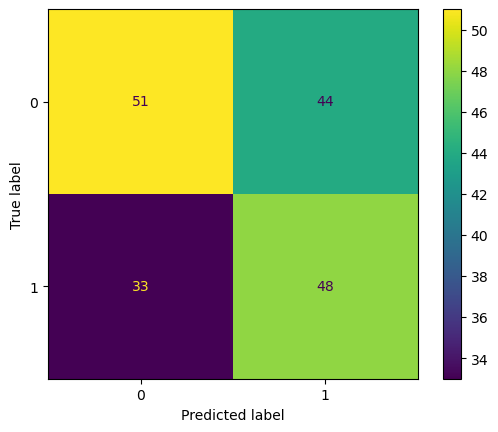

In [18]:
#docs_infra: no_execute
classes = [0, 1, 2, 3, 4]
classes = [0, 1]
cm=confusion_matrix(y_test_def2, y_pred2,labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [19]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test_def2, y_pred2, target_names=target_names, digits=4))

              precision    recall  f1-score   support

     class 0     0.6071    0.5368    0.5698        95
     class 1     0.5217    0.5926    0.5549        81

    accuracy                         0.5625       176
   macro avg     0.5644    0.5647    0.5624       176
weighted avg     0.5678    0.5625    0.5630       176



In [20]:
# model.save('modelos/modelote1203_200')  # creates a HDF5 file 'my_model.h5'

In [21]:
model.save('modelos/modelo_perfecto_{}_{}'.format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

INFO:tensorflow:Assets written to: modelos/modelo_perfecto_LOMOS_P2yP1_GRU2_2_clasesfiltrado_50_dense_onehot_50_loss_categorical_crossentropy_lr_0.001_algoritmo_RMSprop_20240521-190851/assets


INFO:tensorflow:Assets written to: modelos/modelo_perfecto_LOMOS_P2yP1_GRU2_2_clasesfiltrado_50_dense_onehot_50_loss_categorical_crossentropy_lr_0.001_algoritmo_RMSprop_20240521-190851/assets


In [22]:
from scipy import stats
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_def)
#y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
n = len(y_pred2)
reshaped = y_pred2[:n//4*4].reshape(-1, 4)
mean_values = reshaped.mean(axis=1)

mean_values = np.round(mean_values)
mean_values = np.clip(mean_values, 0, 4)
mean_values = mean_values.astype(int)
print(mean_values)

mode_values = stats.mode(reshaped, axis=1)[0]
print(mode_values)

# Convierte los arrays a DataFrames
mean_df = pd.DataFrame(mean_values, columns=['mean'])
mode_df = pd.DataFrame(mode_values, columns=['mode'])

# Guarda los DataFrames en archivos Excel
mean_df.to_excel("clasificacion_P1P2_mean_best7.xlsx", index=False)
mode_df.to_excel("clasificacion_P1_mode_best7.xlsx", index=False)

6/6 [==============================] - 0s 27ms/step
[0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0]
[0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0]


In [23]:
print(y_pred2)

[0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0
 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0
 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0
 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0]


In [34]:
filename5 = "hdf_lomosP1P2_test_def.hdf"
with pd.HDFStore(filename5,complib="zlib",complevel=4) as hdf_db:
    pre_p_e2  = hdf_db.get('data/pollos_estado')
    pre_p_e2 = pre_p_e2.loc[pre_p_e2['Pollo'] != 0]
    pre_p_e2 =pre_p_e2.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_test2=np.zeros((pre_p_e2.shape[0],220,8))
    y_test2=np.zeros((pre_p_e2.shape[0],1))
    x=0
    for index, row in pre_p_e2.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if estado == 0 or estado== 1:
           target = 1
        else:
           target = 0
        #target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_test2[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_test2[x]=target
        y_test2_to_categorical = to_categorical(y_test2)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_test2_filtrado = X_test2
#y_train_filtrado = y_train
y_test2_filtrado = y_test2_to_categorical

print(X_test2_filtrado.shape)
print(y_test2_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
# concatenamos train y test
#X_total=np.concatenate((X_train_filtrado,X_test_filtrado),axis=0)
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_2d_test = X_total.reshape(-1, X_total.shape[-1])
data_2d_test = X_test2_filtrado.reshape(-1, X_test2_filtrado.shape[-1])
normalized_data_2d_test = scaler.transform(data_2d_test)


X_test2_def=normalized_data_2d_test.reshape(X_test2_filtrado.shape) 
# la alternativa es normalizar con el total
# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 

y_test2_def=y_test2_filtrado # los valores ya estaban normalizados

print(y_test2_def.shape)

(200, 220, 8)
(200, 2)
(200, 2)


In [38]:
from scipy import stats
from sklearn.metrics import classification_report

# Crear un nuevo modelo con la misma arquitectura
best_val_model = create_model()  # Reemplaza esto con la función que usaste para crear el modelo original

# Cargar los mejores pesos
best_val_model.load_weights('best_weights.h5')

y_pred = best_val_model.predict(X_test2_def)
#y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
n = len(y_pred2)
print(n)
reshaped = y_pred2[:n//4*4].reshape(-1, 4)
mean_values = reshaped.mean(axis=1)

mean_values = np.round(mean_values)
mean_values = np.clip(mean_values, 0, 4)
mean_values = mean_values.astype(int)
print(mean_values.shape)

mode_values = stats.mode(reshaped, axis=1)[0]
print(mode_values.shape)

n = len(y_test2_def)
y_test_def2=np.argmax(y_test2_def,axis=1)
print(y_test_def2.shape)
print(n)
reshaped2 = y_test_def2[:n//4*4].reshape(-1, 4)
target_mean_values = reshaped2.mean(axis=1)

target_mean_values = np.round(target_mean_values)
target_mean_values = np.clip(target_mean_values, 0, 4)
target_mean_values = target_mean_values.astype(int)
print(target_mean_values.shape)

target_mode_values = stats.mode(reshaped2, axis=1)[0]
print(target_mode_values.shape)

7/7 [==============================] - 0s 21ms/step
200
(50,)
(50,)
(200,)
200
(50,)
(50,)


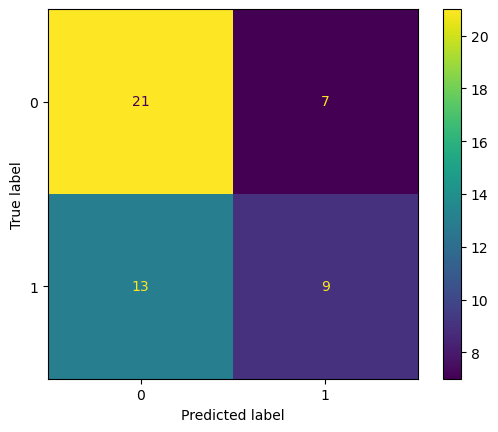

In [39]:
#docs_infra: no_execute
classes = [0, 1, 2, 3, 4]
classes = [0, 1]
cm=confusion_matrix(target_mean_values, mean_values,labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [40]:
print(cm.diagonal()/cm.sum(axis=1))

[0.75       0.40909091]


In [41]:
target_names = ['class 0', 'class 1']
print(classification_report(target_mean_values, mean_values, target_names=target_names, digits=4))

              precision    recall  f1-score   support

     class 0     0.6176    0.7500    0.6774        28
     class 1     0.5625    0.4091    0.4737        22

    accuracy                         0.6000        50
   macro avg     0.5901    0.5795    0.5756        50
weighted avg     0.5934    0.6000    0.5878        50

